In [ ]:
#imports
import pandas as pd
import numpy as np

#!pip install imbalanced-learn
#!pip install nltk
#!pip install langdetect

import warnings
warnings.filterwarnings("ignore")

#from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

from copy import deepcopy

# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag

from langdetect import detect_langs
import string # 
import re # regex
import itertools # flattening

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet = True)
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# tensorflow?

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
### Data Exploration

In [306]:
df = pd.read_csv('data/train.csv')
#df['comment_text'].iloc[0]
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [307]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [308]:
df.dropna(inplace = True)

In [309]:
# inspecting toxic comments
toxic = df.loc[df['toxic'] == 1]
toxic

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [ ]:
# inspecting toxic comments
normal = df.loc[df['toxic'] == 0]
normal

In [74]:
# inspecting a selected comment
print(df.iloc[12]['comment_text'])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [75]:
# checking the toxicity for the selected comment
print(df.iloc[12][df.columns[2:]])

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object


In [76]:
# checking value_counts for each column
values = df.iloc[:,2:].sum()
values

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

### Preprocessing

In [311]:
# converting the comment text to lowercase
df['comment_text'] = df['comment_text'].str.lower()


In [312]:
# Define the function to remove non-English characters
import re
# remove any characters that are not english
regex = re.compile('[^A-Za-z0-9]+')
def remove_non_english(string):
    return regex.sub(' ', string)

# Use the apply method to apply the remove_non_english function to each value in the specified column
df['comment_text'] = df['comment_text'].apply(remove_non_english)

In [313]:
# Remove the links using the apply method
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'https?:\S+', '', x))

In [314]:
# tokenizing
pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(pattern)
df['comment'] = df['comment_text'].apply(tokenizer.tokenize)

In [315]:
# removing stopwords
words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá','aaaaaaaaaah','aaaaaaw','aaaaah','aaaah','aaaawwww','aaages','aaaghh','aaahhh','aaahs', 'wikipedia','길자비','길잡이','날짐승','날찜승','맛있다','잡아야','조선인민군', '척뉴넘','칠지도']
stopwords = stopwords.words('english')
# adding punctuations to stopwords
stopwords += list(string.punctuation) 
stopwords += words

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords]
    return stopwords_removed

In [316]:
df['comment_clean'] = df['comment'].apply(remove_stopwords)

In [317]:
# frequency Distribution
df['comment_clean'].explode()

0         explanation
0               edits
0                made
0            username
0            hardcore
             ...     
159570             go
159570           away
159570        instead
159570        helping
159570        rewrite
Name: comment_clean, Length: 5600233, dtype: object

In [318]:
def visualize_top_10(freq_dist, title):
    
    # extract data from plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    # creating plot
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
    # customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))
    ax.tick_params(axis = "x", rotation = 90)

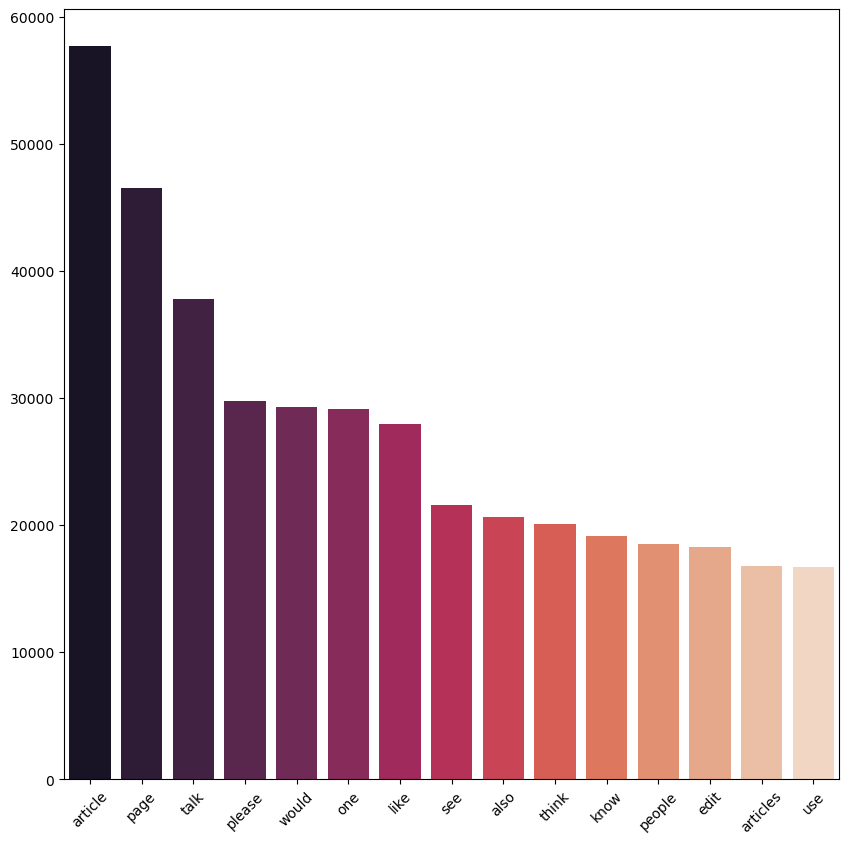

In [319]:
# visualize frequency distiribution of full dataset
freq_dist = FreqDist(df["comment_clean"].explode())

# plot the top 10 words
#visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")
#plt.figure(figsize=(10,10))
#freq_dist.plot(20);
fig, ax = plt.subplots(figsize = (10, 10))
top_20 = list(freq_dist.most_common(15))
labels = [i[0] for i in top_20]
values = [i[1] for i in top_20]
sns.barplot(x = labels, y = values, palette = 'rocket', ax=ax)
plt.xticks(rotation=45);

In [320]:
toxic = df[df['toxic'] == 1]

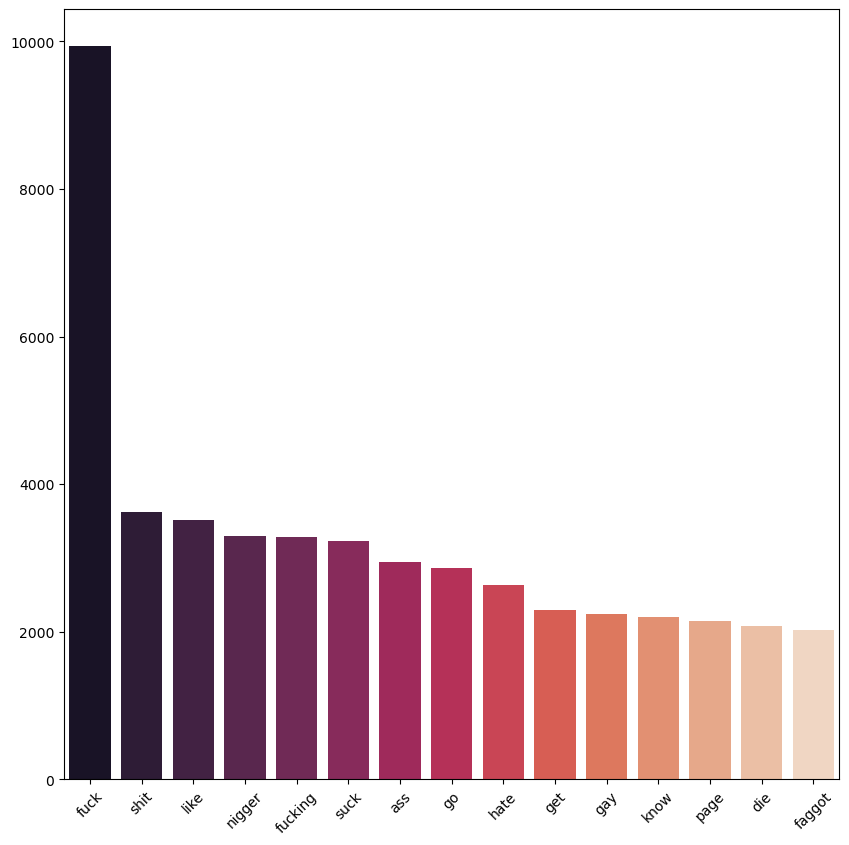

In [321]:
# visualize frequency distiribution of toxic dataset
freq_dist_toxic = FreqDist(toxic['comment_clean'].explode())

# plot the top 10 words
#visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")
#plt.figure(figsize=(10,10))
#freq_dist.plot(20);

fig, ax = plt.subplots(figsize = (10, 10))
top_20 = list(freq_dist_toxic.most_common(15))
labels = [i[0] for i in top_20]
values = [i[1] for i in top_20]
sns.barplot(x = labels, y = values, palette = 'rocket' , ax=ax)
plt.xticks(rotation=45);

In [ ]:
# creating wordCloud of most frequent toxic words
wordcloud = WordCloud(width = 600, height = 400,
                colormap="vlag", background_color ='black',
                min_font_size = 10, random_state = 30).generate_from_frequencies(freq_dist_toxic)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [323]:
# removing numeric characters with regex
df['comment_clean'] = df['comment_clean'].apply(lambda x: x if not isinstance(x, str) else x.replace(r'\d', ''))

In [326]:
stop_words = stopwords.words('english')
# adding punctuations to stopwords
stop_words += list(string.punctuation)

In [364]:
# tokenization and stemming function
snowball_stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    tok_doc = [snowball_stem.stem(token.lower()) for token in tokens]
    return tok_doc

In [365]:
# stemming stopwords
stemmed_stopwords = [snowball_stemmer.stem(word) for word in stop_words]

### Preprocessing

In [366]:
#targets= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text']
y = df['toxic']

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

### Model1 - MultinomialNB - base model

In [381]:
#TfidfTransformer??

In [390]:
# initialize the countVectorizer
#tfidf = TfidfVectorizer(stop_words = stemmed_stopwords, tokenizer = stem_and_tokenize)

In [369]:
# X_train_stem = tfidf.fit_transform(X_train)
# X_val_stem = tfidf.fit_transform(X_val)
# X_test_stem = tfidf.transform(X_test)

In [197]:
# checking the original imbalance
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [382]:
pipe1 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),('tranf', TfidfTransformer()),
                 ('multinb', MultinomialNB())])

In [383]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('multinb', MultinomialNB())])

In [384]:
pipe1.score(X_test,y_test)

0.9216669277769074

In [385]:
y_pred = pipe1.predict(X_test)

In [409]:
y_pred_proba = pipe1.predict_proba(X_test)[:,1]

In [410]:
y_pred_proba

array([0.00170682, 0.00092006, 0.01569012, ..., 0.00196667, 0.00061353,
       0.00077207])

In [425]:
model1 = classification_report(y_test, y_pred)
print(model1)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [413]:
roc_auc_score(y_test, y_pred_proba)

0.8873885664003913

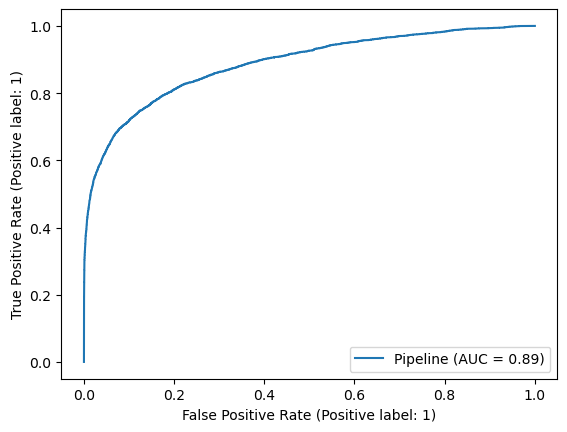

In [414]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe1, X_test, y_test)

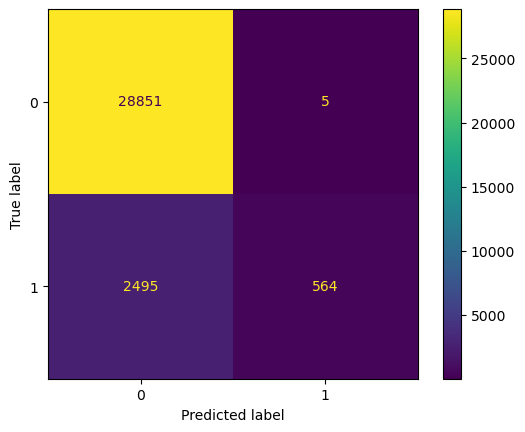

In [389]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test);

### Model2 - MultinomialNB with SMOTE

In [ ]:
# adding SMOTE for the baseline model

In [391]:
pipe2 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB())])

In [392]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('multinb', MultinomialNB())])

In [393]:
pipe2.score(X_test,y_test)

0.923985586714711

In [394]:
y_pred = pipe2.predict(X_test)

In [415]:
y_pred_proba = pipe2.predict_proba(X_test)[:,1]

In [424]:
model2 = classification_report(y_test, y_pred)
print(model2)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [416]:
roc_auc_score(y_test, y_pred_proba)

0.946671483828845

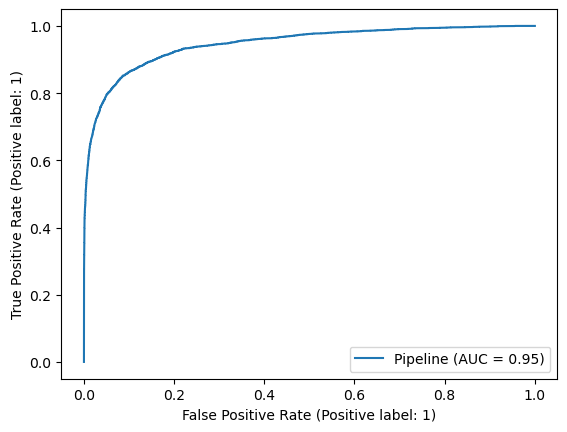

In [397]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe2, X_test, y_test)

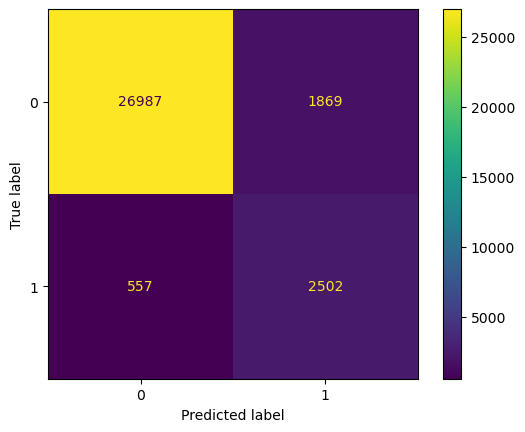

In [398]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test);

In the next model I will run a grid search for the SMOTEd multinomialNB model.

### Model3 - MultinomialNB - best params

In [399]:
# gridsearch for multinomialNB
param_grid = {
    'countvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'multinb__alpha': [1, 1e-1, 1e-2, 0.5, 10],
    'multinb__fit_prior': [True, False]
}

clf = GridSearchCV(estimator = pipe2, param_grid = param_grid, cv=5, scoring='recall', n_jobs=-1)

In [400]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'our',
                                                                    'ourselv',
                                                                    'you',
                                                                    "you'r",
                                                                    "you'v",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'your',
                                                                    'yourself',
                                                                    'yourselv',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'she',
                                                                    'her',
                                                                    'her',
                                                                    'herself',
                                                                    'it', 'it',
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                                       ('tranf', TfidfTransformer()),
                                       ('smote', SMOTE()),
                                       ('multinb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'multinb__alpha': [1, 0.1, 0.01, 0.5, 10],
                         'multinb__fit_prior': [True, False]},
             scoring='recall')

In [401]:
clf.best_params_

{'countvec__ngram_range': (1, 1),
 'multinb__alpha': 0.5,
 'multinb__fit_prior': False}

In [ ]:
CountVectorizer??

In [402]:
pipe3 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, )),('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB(alpha = 0.5,
                                           fit_prior = False))])

In [403]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('multinb', MultinomialNB(alpha=0.5, fit_prior=False))])

In [417]:
pipe3.score(X_test,y_test)

0.9164029453235156

In [418]:
y_pred = pipe3.predict(X_test)

In [419]:
y_pred_proba = pipe3.predict_proba(X_test)[:,1]

In [420]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [421]:
roc_auc_score(y_test, y_pred_proba)

0.9465545364961323

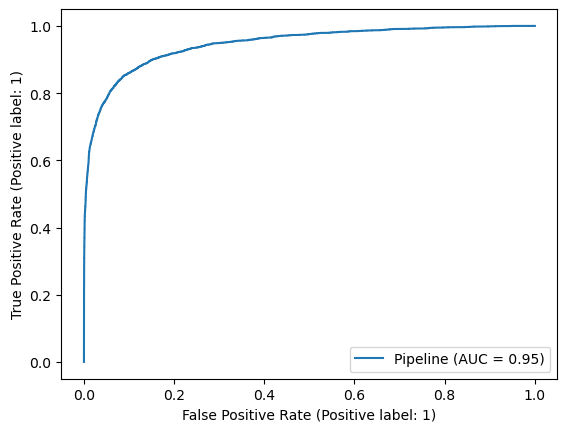

In [426]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe3, X_test, y_test)

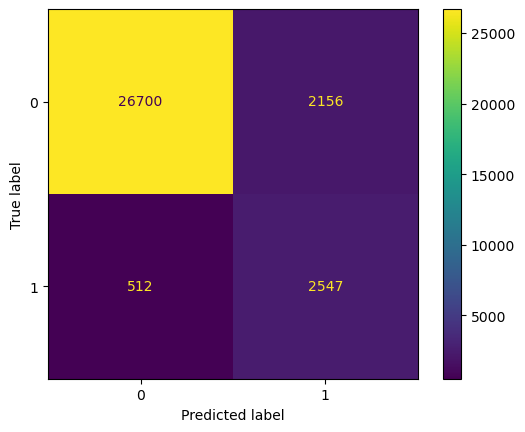

In [423]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe3, X_test, y_test);

Running the model with the best params returned by the gridSearchCV didn't change the scores. It only made changes to the number of false negatives and false positives.

### Model4- MultinomialNB - best params - TfidfVectorizer

In [ ]:
pipe4 = Pipeline([('tfidf', TfidfVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB(alpha = 0.5,
                                           fit_prior = False))])

In [ ]:
pipe4.fit(X_train, y_train)

In [ ]:
pipe4.score(X_test,y_test)

In [ ]:
y_pred = pipe4.predict(X_test)
y_pred_proba = pipe4.predict_proba(X_test)[:,1]

In [ ]:
model4 = classification_report(y_test, y_pred)
print(model4)

In [ ]:
roc_auc_score(y_test, y_pred_proba)

In [ ]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe4, X_test, y_test)

In [ ]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe4, X_test, y_test);

This model with the TfidfVectorizer performed worst then the previous one with the countVectorizer. Compared to Model2 which had the lowest false negative (FN:557), false positive (FP:1869) pair, this model's FN jumped to 1552, while the FN more then trippeled to 7395. The Recall on class 1 is also down to 49% from 83%, the F1 score fell to 25%, from 66%, and the Accuracy also decreased from 92% to 72%. Lastly the AUC also decreased from 95% to 74%.

### Model5 - RandomForest - with tfidfVectorizer

In [435]:
pipe5 = Pipeline([('tfidf', TfidfVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, min_df=0.05, max_df=0.95)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier())])

In [436]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=0.05,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest', RandomForestClassifier())])

In [437]:
pipe5.score(X_test,y_test)

0.7724894250352499

In [438]:
y_pred = pipe5.predict(X_test)
y_pred_proba = pipe5.predict_proba(X_test)[:,1]

In [439]:
model5 = classification_report(y_test, y_pred)
print(model5)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     28856
           1       0.23      0.57      0.33      3059

    accuracy                           0.77     31915
   macro avg       0.59      0.68      0.59     31915
weighted avg       0.88      0.77      0.81     31915



In [440]:
roc_auc_score(y_test, y_pred_proba)

0.7398743639211578

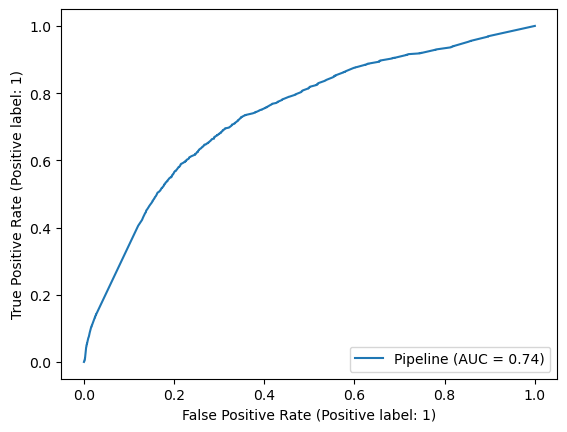

In [441]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe5, X_test, y_test)

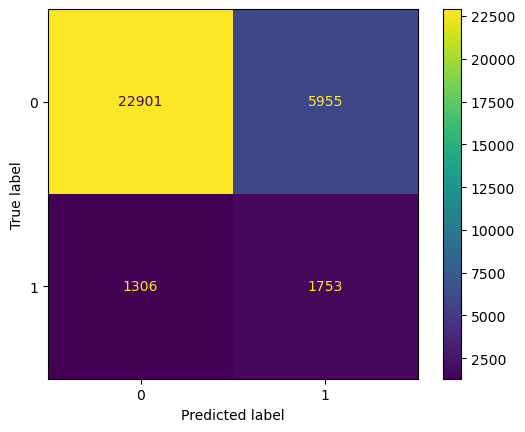

In [442]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe5, X_test, y_test);

This RandomForest model still performing worst then the selected best model (Model2) so far, however the scores and the number of FN and FP are stightly improved from the previous model (Model4).
In the following I will try to run this model with countVectorizer and see if it is performing better then with tfidf.


### Model5b - RandomForest - with CountVectorizer

In [454]:
pipe5b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, min_df=0.05, max_df=0.95)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier())])

In [455]:
pipe5b.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(max_df=0.95, min_df=0.05,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest', RandomForestClassifier())])

In [456]:
pipe5b.score(X_test,y_test)

0.7686354378818737

In [457]:
y_pred = pipe5b.predict(X_test)
y_pred_proba = pipe5b.predict_proba(X_test)[:,1]

In [458]:
model5b = classification_report(y_test, y_pred)
print(model5b)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     28856
           1       0.22      0.57      0.32      3059

    accuracy                           0.77     31915
   macro avg       0.58      0.68      0.59     31915
weighted avg       0.88      0.77      0.81     31915



In [459]:
roc_auc_score(y_test, y_pred_proba)

0.7371985776811698

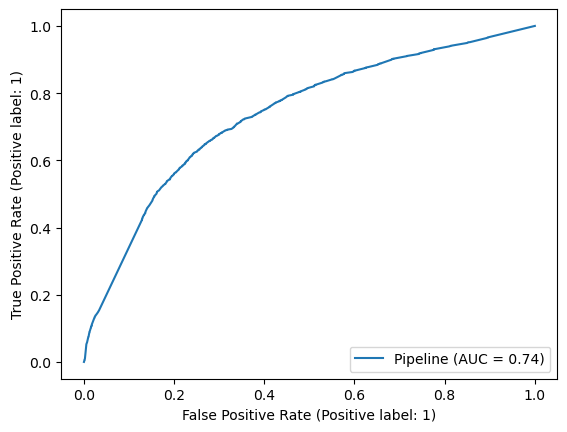

In [460]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe5b, X_test, y_test)

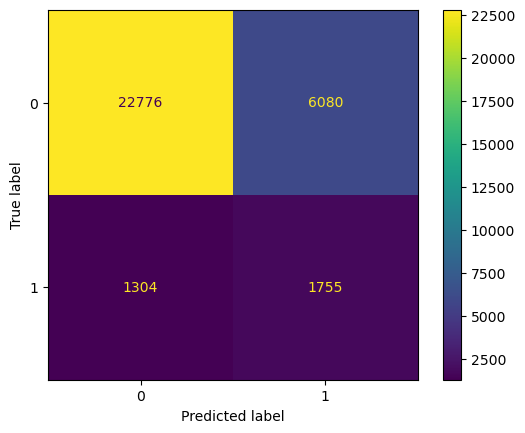

In [461]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe5b, X_test, y_test);

I will run a gridSearchCV for the RandomForest to get the optimal parameters to see if it will improve the model.

### Model6 - RanomForest - CountVectorizer - best params

In [480]:
# running a GridSearchCV for RandomForest
rf_params = param_grid = {'forest__criterion': ['gini', 'entropy'], 
                          'forest__n_estimators': [30, 50, 150], 
                          'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__max_depth': [3, 5, 7]}

rf_grid_pipe = GridSearchCV(estimator = pipe5b, param_grid = rf_params, scoring = 'recall', cv = 3, n_jobs = -1)


In [481]:
# fitting the train
rf_grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(max_df=0.95,
                                                        min_df=0.05,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'our',
                                                                    'ourselv',
                                                                    'you',
                                                                    "you'r",
                                                                    "you'v",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'your',
                                                                    'yourself',
                                                                    'yourselv',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'she',
                                                                    'her',
                                                                    'her',
                                                                    'herself',
                                                                    'it', 'it',
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                                       ('tranf', TfidfTransformer()),
                                       ('smote', SMOTE()),
                                       ('forest', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'forest__criterion': ['gini', 'entropy'],
                         'forest__max_depth': [3, 5, 7],
                         'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__n_estimators': [30, 50, 150]},
             scoring='recall')

In [482]:
# displaying the best params
rf_grid_pipe.best_params_

{'forest__criterion': 'gini',
 'forest__max_depth': 3,
 'forest__min_samples_leaf': 50,
 'forest__n_estimators': 30}

In [483]:
pipe7 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, min_df=0.05, max_df=0.95)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 50,
                                                  n_estimators = 30))])

In [484]:
pipe7.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(max_df=0.95, min_df=0.05,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=50,
                                        n_estimators=30, random_state=43))])

In [485]:
pipe7.score(X_test,y_test)

0.6186119379602067

In [486]:
y_pred = pipe7.predict(X_test)
y_pred_proba = pipe7.predict_proba(X_test)[:,1]

In [487]:
model6 = classification_report(y_test, y_pred)
print(model6)

              precision    recall  f1-score   support

           0       0.96      0.60      0.74     28856
           1       0.17      0.77      0.28      3059

    accuracy                           0.62     31915
   macro avg       0.57      0.69      0.51     31915
weighted avg       0.89      0.62      0.70     31915



In [488]:
roc_auc_score(y_test, y_pred_proba)

0.741918455569258

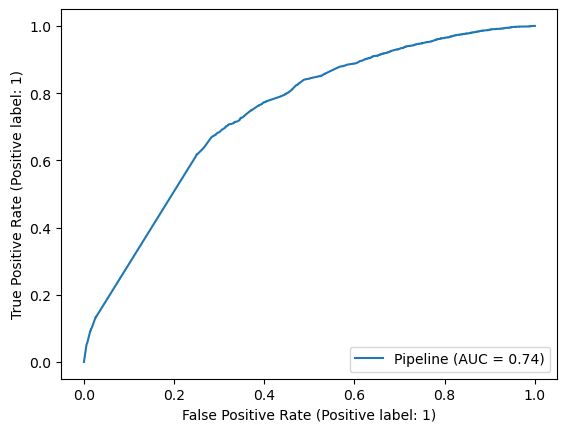

In [489]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe7, X_test, y_test)

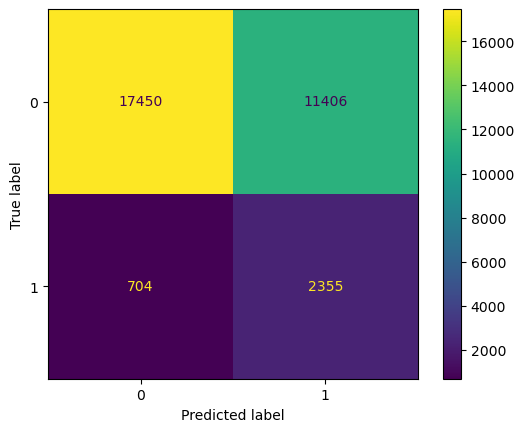

In [453]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7, X_test, y_test);

Model6 did not perform better then Model5b. The number of FN decreased almost 50%, however the number of FP increased almost two fold.
In the following I will check this model's performance with RandomOverSampler instead of SMOTE.


In [492]:
pipe7b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, min_df=0.05, max_df=0.95)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state=46)),
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 50,
                                                  n_estimators = 30))])

In [493]:
pipe7b.fit(X_train, y_train)


Pipeline(steps=[('countvec',
                 CountVectorizer(max_df=0.95, min_df=0.05,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()),
                ('over', RandomOverSampler(random_state=46)),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=50,
                                        n_estimators=30, random_state=43))])

In [474]:
pipe7b.score(X_test,y_test)

0.6036033213222622

In [475]:
y_pred = pipe7b.predict(X_test)
y_pred_proba = pipe7b.predict_proba(X_test)[:,1]

In [476]:
model6b = classification_report(y_test, y_pred)
print(model6b)

              precision    recall  f1-score   support

           0       0.96      0.58      0.73     28856
           1       0.17      0.79      0.28      3059

    accuracy                           0.60     31915
   macro avg       0.57      0.69      0.50     31915
weighted avg       0.89      0.60      0.68     31915



In [477]:
roc_auc_score(y_test, y_pred_proba)

0.7408519384912541

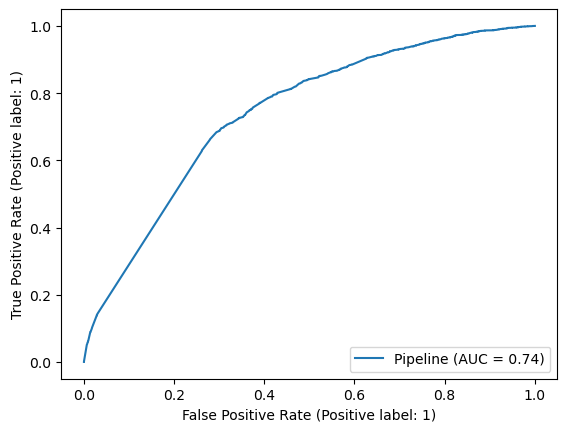

In [478]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe7b, X_test, y_test)

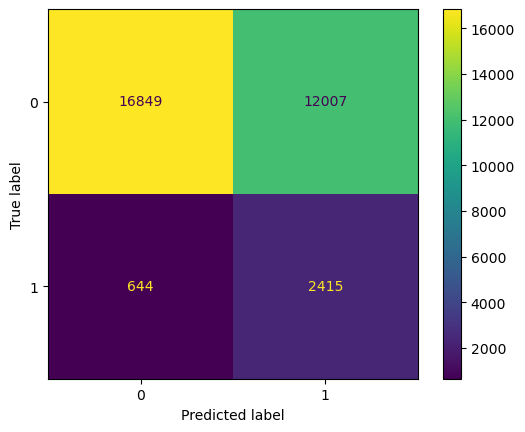

In [479]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7b, X_test, y_test);

RandomOverSampling did not improve the the model. 
I the following I will build an XGBoost model.

### Model7 - XGBoost


In [502]:
pipe8 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state= 50)),
                 ('xgb', XGBClassifier(random_state = 50))])

In [503]:
pipe8.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer(...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=50, ...))])

In [504]:
pipe8.score(X_test,y_test)

0.9465141782860724

In [505]:
y_pred = pipe8.predict(X_test)
y_pred_proba = pipe8.predict_proba(X_test)[:,1]

In [506]:
model7 = classification_report(y_test, y_pred)
print(model7)


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28856
           1       0.69      0.79      0.74      3059

    accuracy                           0.95     31915
   macro avg       0.84      0.88      0.85     31915
weighted avg       0.95      0.95      0.95     31915



In [507]:
roc_auc_score(y_test, y_pred_proba)

0.9486387038188884

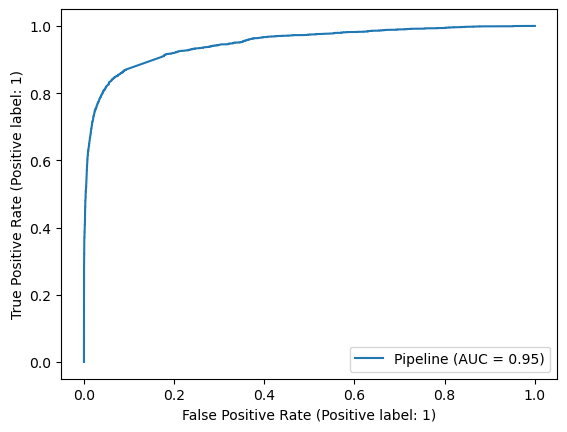

In [508]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe8, X_test, y_test)

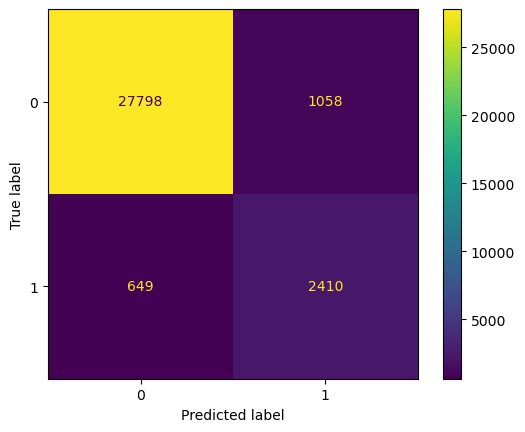

In [509]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe8, X_test, y_test);

In [510]:
# Performing a grid search for our XGBoost
xgb_params = {
    'xgb__gamma': [0.5, 1, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__n_estimators': [50, 100, 150, 200],
}

xgb_grid = GridSearchCV(estimator = pipe8, param_grid = xgb_params, scoring = 'recall', cv = 3)

In [ ]:
# Fitting the training data
xgb_grid.fit(X_train_proc, y_train)

In [ ]:
# Returning the best parameters as a result of the grid search
xgb_grid.best_params_

In [ ]:
# re-running the model with the best params
pipe8b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state= 50)),
                 ('xgb', XGBClassifier(random_state = 51,
                                                 gamma = 0.5,
                                                 learning_rate = 0.1,
                                                 max_depth = 3,
                                                 min_child_weight = 10,
                                                 n_estimators = 50))])

In [ ]:
#SVC - suport vector classifier

### Ensemble method - Stacking

In [155]:
estimators = [
    ('multinb', MultinomialNB(alpha = 0.5,
                              fit_prior = False)),
    ('forest', RandomForestClassifier(criterion = 'gini',
                                     max_depth = 3,
                                     min_samples_leaf = 50,
                                     n_estimators = 30)),
    ('xgb', XGBClassifier(gamma = 0.5,
                         learning_rate = 0.1,
                         max_depth = 3,
                         min_child_weight = 1,
                         n_estimators = 50))
]

In [156]:
sr = StackingClassifier(estimators)


In [157]:
pipe7 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                  ('ens', sr)])

In [158]:
pipe7.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('ens',
                 StackingClassifier(estimators=[('multinb', MultinomialNB()),
                                                ('forest',
                                                 RandomForestClassifier(max_depth=3,
                                                                        min_samples_leaf=5,
                                                                        n_estimators=50)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=Non...
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=50,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))])

In [167]:
pipe7.score(X_test_proc, y_test)

0.9911953626821244

In [168]:
y_pred7 = pipe7.predict(X_test_proc)

In [169]:
roc_auc_score(y_test, y_pred7)

0.5

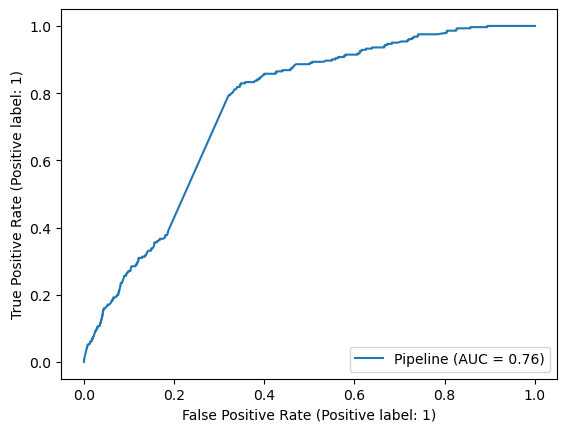

In [170]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe7, X_test_proc, y_test)

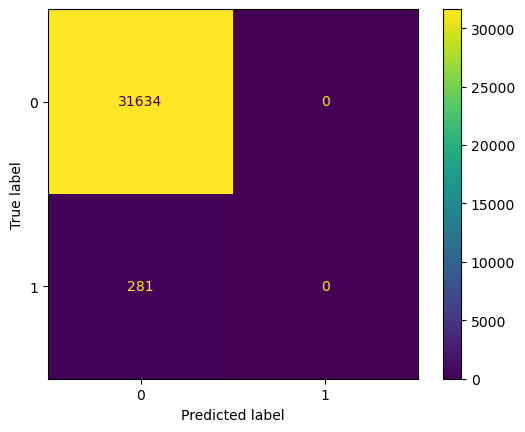

In [171]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7, X_test_proc, y_test);